# ****Importing Models****

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,LSTM,Embedding,Conv1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import seaborn as sns

# ****Training data review****

In [2]:
train_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/train.tsv', sep='\t')
train_data.head()

,date,time,id,reviewer name,reviewer address,contact number,variation,verified_reviews,sentiment,feedback
0,30-Jul-18,02:16:00,5138527,Theresa Diaz,"2373 Long Mews\nSouth Lorraine, FL 83715",7445448464,Black Plus,Love my new Echo Plus,5,1
1,30-Jul-18,20:13:24,7881409,Michael Wagner,"34120 James Well Apt. 930\nSouth Kenneth, AK 5...",(202)233-6662,Configuration: Fire TV Stick,Works really well.,5,1
2,29-Jul-18,03:20:48,5658396,Erin Rodriguez,"7996 Booth Mission\nTaylorport, AL 13457",(219)882-0705,Black Show,Echo Show is said to work with certain apps bu...,2,0
3,30-Jul-18,22:48:21,4317957,Christine Perez,USS Schaefer\nFPO AA 86432,291-900-6087,Heather Gray Fabric,Very cool product. Speaker sounds good with my...,5,1
4,23-Jul-18,12:36:42,7570569,Jamie Davila,"000 Kevin Cliffs Suite 674\nBrennanview, NM 77690",9527296610,Black Plus,So far I love it. It was easy to set up - if ...,5,1


In [3]:
train_data.isnull().sum()

date                0
time                0
id                  0
reviewer name       0
reviewer address    0
contact number      0
variation           0
verified_reviews    1
sentiment           0
feedback            0
dtype: int64

In [4]:
train_data.fillna({"verified_reviews":"no review"}, inplace=True)

# ****Downloading RoBERTa transformer model****

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# ****Training Data preprocessing and feature engineering****

In [6]:
from scipy.special import softmax
pov_review=[]
neg_review=[]
neu_review=[]
com_review=[]
pov_ratings=[]
neu_ratings=[]
neg_ratings=[]
for i in train_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        neg_review.append(scores[0])
        neu_review.append(scores[1])
        pov_review.append(scores[2])
        com_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        if max(scores)==scores[0]:
            neg_ratings.append(1.0)
            neu_ratings.append(0.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_ratings.append(0.0)
            neu_ratings.append(1.0)
            pov_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_ratings.append(0.0)
            neu_ratings.append(0.0)
            pov_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_review.append(1.0)
        neg_review.append(0.0)
        neu_review.append(0.0)
        com_review.append(1.0)
        neg_ratings.append(0.0)
        neu_ratings.append(0.0)
        pov_ratings.append(1.0)

1
1


In [7]:
ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform([[item] for item in train_data['variation']])
print(max([i[0] for i in encoded_data]))

15.0


In [8]:
new_dataframe=pd.DataFrame({"positive":pov_review,"negative":neg_review,"neutral":neu_review,"combined":com_review,"feedback":list(map(lambda x: float(x),train_data['feedback'])),"isPositive":pov_ratings,"isNegative":neg_ratings,"isNeutral":neu_ratings ,"item":[i[0] for i in encoded_data],})
new_dataframe.head()

,positive,negative,neutral,combined,feedback,isPositive,isNegative,isNeutral,item
0,0.989508,0.001466,0.009026,0.989550,1.0,1.0,0.0,0.0,2.0
1,0.936137,0.004737,0.059127,0.938014,1.0,1.0,0.0,0.0,6.0
2,0.107922,0.570545,0.321533,0.663741,0.0,0.0,1.0,0.0,3.0
3,0.988388,0.001345,0.010267,0.988442,1.0,1.0,0.0,0.0,7.0
4,0.991431,0.002093,0.006476,0.991454,1.0,1.0,0.0,0.0,2.0


# ****Data Visualization****

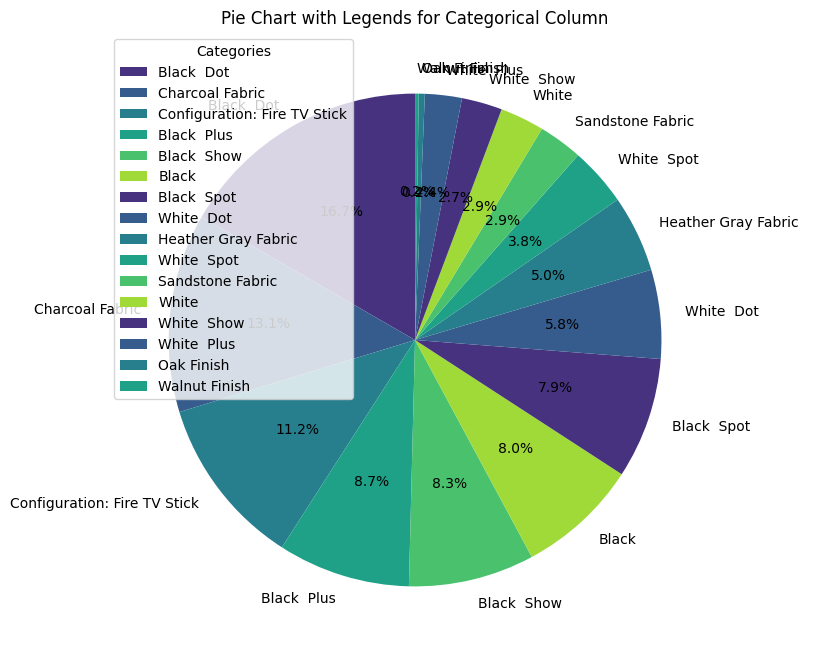

In [9]:
plt.figure(figsize=(8, 8))
plt.pie(train_data['variation'].value_counts().values, labels=train_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=train_data['variation'].value_counts().index, loc='best')
plt.show()

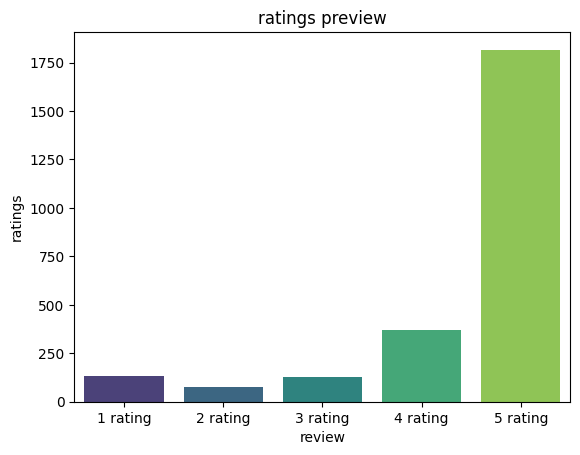

In [10]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in train_data['sentiment'] if i==1.0]),sum([1 for i in train_data['sentiment'] if i==2.0]),sum([1 for i in train_data['sentiment'] if i==3.0]),sum([1 for i in train_data['sentiment'] if i==4.0]),sum([1 for i in train_data['sentiment'] if i==5.0])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('ratings preview')
plt.show()

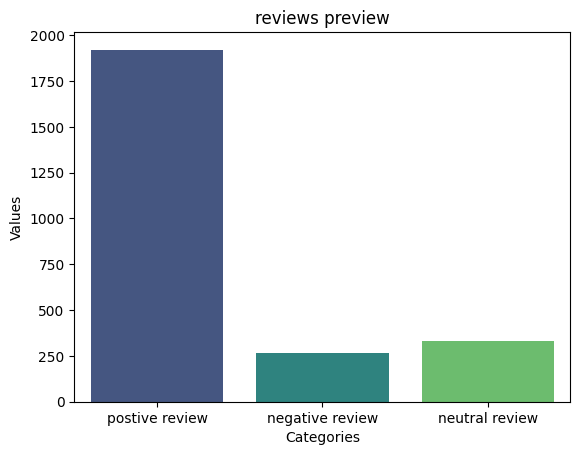

In [11]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_ratings),sum(neg_ratings),sum(neu_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('reviews preview')
plt.show()

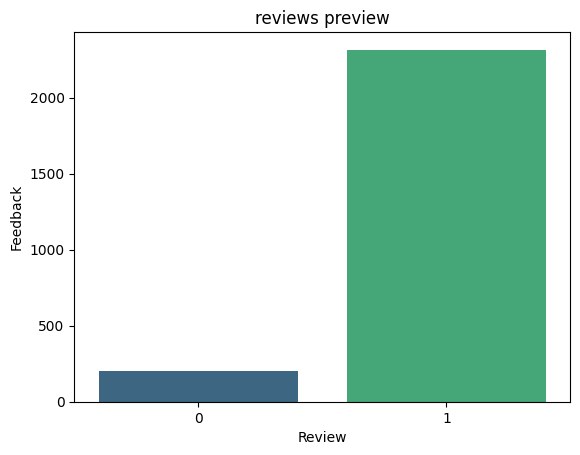

In [12]:
sns.barplot(x=["0","1"],y=[sum([1 for i in train_data['feedback'] if i==0.0]),sum([1 for i in train_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('reviews preview')
plt.show()

graphs to be made:no of positive,negative and neutrals,(barchart)
graph on feedback
barchart on ratings
variation graph
confusion matrix and related graphs


# ****Training RandomForestClassifier on data featured out****

In [13]:
X_train, X_test, y_train, y_test = train_test_split(new_dataframe, train_data['sentiment'],  test_size=0.1, random_state=42) 
dtree_model = RandomForestClassifier(n_estimators=2000 ,random_state=0).fit(X_train, y_train)
dtree_predictions = dtree_model.score(X_test,y_test) 
print(dtree_predictions)

0.8015873015873016


# ****Model Analysis****

0.6722124357912498


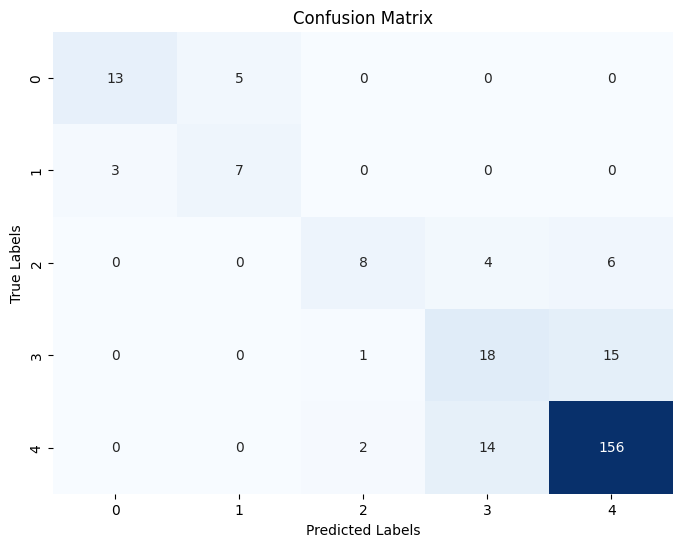

In [14]:
y_pred = dtree_model.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(macro_f1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ****Testing Data preprocessing and feature engineering****

In [15]:
test_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-space-shop/test.tsv', sep='\t')
pov_test_review=[]
neg_test_review=[]
neu_test_review=[]
com_test_review=[]
neg_test_ratings=[]
neu_test_ratings=[]
pov_test_ratings=[]
for i in test_data['verified_reviews']:
    try:
        encoded_text = tokenizer(i, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
#         print(scores)
        neg_test_review.append(scores[0])
        neu_test_review.append(scores[1])
        pov_test_review.append(scores[2])
        com_test_review.append((scores[0]**2+scores[1]**2+scores[2]**2)**(0.5))
        if max(scores)==scores[0]:
            neg_test_ratings.append(1.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[1]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(1.0)
            pov_test_ratings.append(0.0)
        elif max(scores)==scores[2]:
            neg_test_ratings.append(0.0)
            neu_test_ratings.append(0.0)
            pov_test_ratings.append(1.0)
    except RuntimeError:
        print(1)
        pov_test_review.append(1.0)
        neg_test_review.append(0.0)
        neu_test_review.append(0.0)
        com_test_review.append(1.0)
        neg_test_ratings.append(0.0)
        neu_test_ratings.append(0.0)
        pov_test_ratings.append(1.0)

In [16]:
encoded_test_data = ordinal_encoder.transform([[item] for item in test_data['variation']])
print(max([i[0] for i in encoded_test_data]))

15.0


In [17]:
test_dataframe=pd.DataFrame({"positive":pov_test_review,"negative":neg_test_review,"neutral":neu_test_review,"combined":com_test_review,"feedback":list(map(lambda x: float(x),test_data['feedback'])),"isPositive":pov_test_ratings,"isNegative":neg_test_ratings,"isNeutral":neu_test_ratings,"item":[i[0] for i in encoded_test_data]})
test_dataframe.head()

,positive,negative,neutral,combined,feedback,isPositive,isNegative,isNeutral,item
0,0.984899,0.002404,0.012697,0.984984,1.0,1.0,0.0,0.0,7.0
1,0.986175,0.003311,0.010514,0.986236,1.0,1.0,0.0,0.0,2.0
2,0.005175,0.963042,0.031783,0.963580,0.0,0.0,1.0,0.0,6.0
3,0.858581,0.032428,0.108991,0.866078,1.0,1.0,0.0,0.0,2.0
4,0.963731,0.003297,0.032972,0.964301,1.0,1.0,0.0,0.0,3.0


# ****Running Model on test data**** 

In [18]:
arr=dtree_model.predict(test_dataframe)
print(arr)

[5 5 1 5 5 5 5 5 2 3 5 5 5 4 5 5 1 5 5 3 5 5 5 5 5 5 1 5 5 1 5 5 5 5 5 5 5
 5 5 5 5 1 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 4 3 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 1 5 5 5 5 2 5 3 5 5 5 5 2 5 5 5 5 5 5 5 5 5 3 1 5 2 5 5 5 5 4 5
 5 1 5 5 5 5 5 5 5 5 4 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 3 5 5 4 5 5 5 5 4 5 2 5 5 3 4 5 5 5 5 5 3 5 5 5 5 4 5 5 1 5 5 5 5 5 2 5
 2 5 5 4 5 5 5 5 5 5 5 4 5 5 5 5 5 5 4 5 5 3 1 4 5 3 5 5 5 5 5 5 4 5 5 5 5
 5 5 5 5 5 5 1 5 5 5 4 5 5 1 4 5 5 3 5 5 5 5 3 5 5 4 3 1 1 5 4 5 5 5 1 5 5
 5 4 3 5 5 5 4 5 5 5 5 3 5 5 2 5 5 5 5 3 5 4 5 3 5 5 5 5 5 5 4 4 5 5 5 5 5
 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 1 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5
 5 5 5 5 5 5 5 5 5 1 5 4 5 5 5 5 5 1 5 5 5 5 4 1 5 5 4 4 4 4 5 5 4 5 5 5 5
 5 5 5 5 1 5 5 5 5 5 1 5 5 5 5 5 5 2 1 3 5 5 5 5 1 3 5 5 1 5 5 3 5 5 5 5 5
 5 5 5 5 4 5 5 5 5 5 5 1 5 4 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4 2 3 5
 3 5 5 4 5 2 5 5 5 2 4 5 5 4 5 5 5 5 5 3 5 5 1 5 5 5 5 5 5 5 4 3 1 5 5 5 5
 5 5 5 3 5 5 5 5 5 1 4 5 

# ****Test data and Result Visualization****

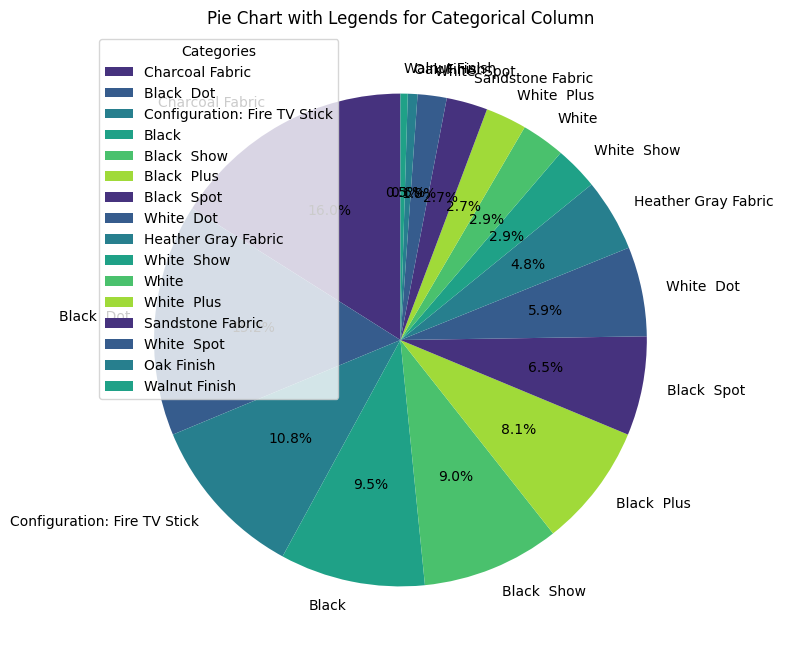

In [19]:
plt.figure(figsize=(8, 8))
plt.pie(test_data['variation'].value_counts().values, labels=test_data['variation'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=test_data['variation'].value_counts().index, loc='best')
plt.show()

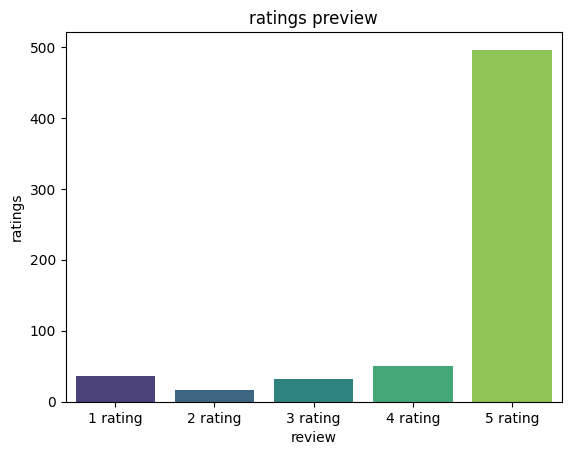

In [20]:
sns.barplot(x=["1 rating","2 rating","3 rating","4 rating","5 rating"],y=[sum([1 for i in arr if i==1]),sum([1 for i in arr if i==2]),sum([1 for i in arr if i==3]),sum([1 for i in arr if i==4]),sum([1 for i in arr if i==5])], palette="viridis")
plt.xlabel('review')
plt.ylabel('ratings')
plt.title('ratings preview')
plt.show()

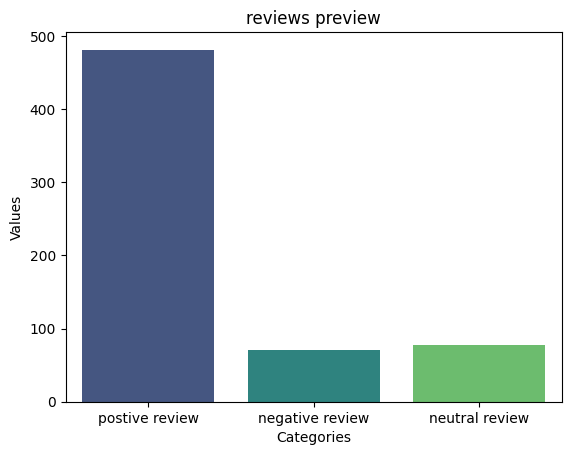

In [21]:
sns.barplot(x=["postive review","negative review","neutral review"],y=[sum(pov_test_ratings),sum(neg_test_ratings),sum(neu_test_ratings)], palette="viridis")
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('reviews preview')
plt.show()

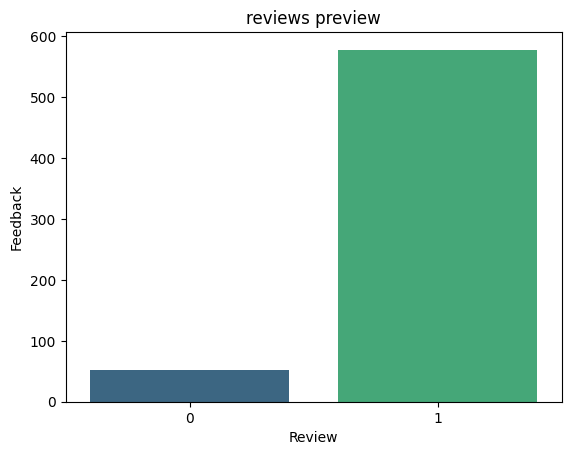

In [22]:
sns.barplot(x=["0","1"],y=[sum([1 for i in test_data['feedback'] if i==0.0]),sum([1 for i in test_data['feedback'] if i==1.0])], palette="viridis")
plt.xlabel('Review')
plt.ylabel('Feedback')
plt.title('reviews preview')
plt.show()

# ****Downloading the CSV file****

In [23]:
submission=pd.DataFrame({"id":test_data['id'],"sentiment":arr})
submission.to_csv("submission6.csv",index=False)